# Automated Anomaly Detection
**Objective**: Understand and practice automated anomaly detection using various techniques.

**Task**: Autoencoders for Anomaly Detection

**Steps**:
1. Data Set: Download a dataset of electricity consumption data.
2. Build an Autoencoder: Construct a simple autoencoder using a neural network for the
normal consumption data.
3. Identify Anomalies: Use the trained model to reconstruct the data and identify anomalies based on reconstruction error.
4. Visualize: Plot both the actual and reconstructed data to highlight anomalies.

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Anomaly detection threshold (reconstruction error): 0.0478
Number of detected anomalies: 29
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


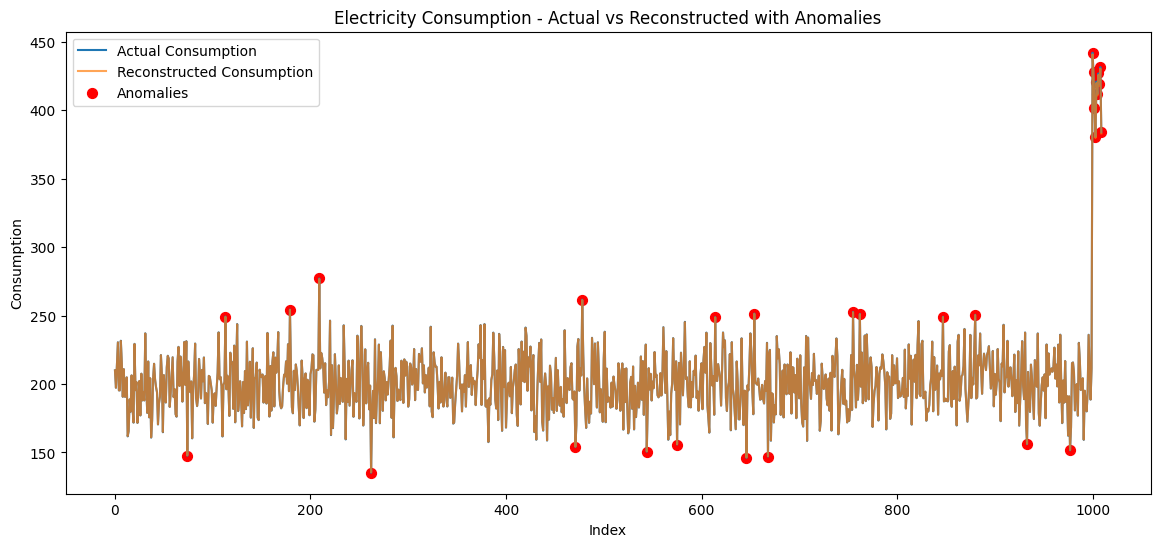

In [6]:
# write your code from here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import unittest

# -------------------------------
# Generate Synthetic Electricity Consumption Data
# -------------------------------
def generate_data(random_seed=42):
    np.random.seed(random_seed)
    # Normal consumption data
    normal_data = np.random.normal(loc=200, scale=20, size=1000)
    # Inject anomalies with higher consumption values
    anomalies = np.random.normal(loc=400, scale=30, size=10)
    # Combine and create DataFrame
    consumption = np.concatenate([normal_data, anomalies])
    df = pd.DataFrame({'consumption': consumption})
    return df

# -------------------------------
# Build Autoencoder Model
# -------------------------------
def build_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(16, activation='relu')(input_layer)
    encoded = Dense(8, activation='relu')(encoded)
    decoded = Dense(16, activation='relu')(encoded)
    decoded = Dense(input_dim, activation='linear')(decoded)
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return autoencoder

# -------------------------------
# Detect Anomalies Using Autoencoder Reconstruction Error
# -------------------------------
def detect_anomalies_with_autoencoder(df, epochs=50, batch_size=32):
    data = df['consumption'].values.reshape(-1, 1)
    autoencoder = build_autoencoder(data.shape[1])

    # Train only on normal data (assumed all except last 10 are normal)
    autoencoder.fit(data[:-10], data[:-10],
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    verbose=0)

    # Reconstruct the data
    reconstructed = autoencoder.predict(data)
    # Calculate reconstruction error
    reconstruction_error = np.mean(np.square(data - reconstructed), axis=1)
    df['reconstruction_error'] = reconstruction_error

    # Define anomaly threshold as mean + 3*std deviation of reconstruction error on training data
    threshold = reconstruction_error[:-10].mean() + 3 * reconstruction_error[:-10].std()
    df['is_anomaly'] = df['reconstruction_error'] > threshold

    return df, threshold, autoencoder

# -------------------------------
# Visualize Actual vs Reconstructed Data & Highlight Anomalies
# -------------------------------
def plot_results(df, autoencoder):
    data = df['consumption'].values.reshape(-1, 1)
    reconstructed = autoencoder.predict(data)

    plt.figure(figsize=(14, 6))
    plt.plot(df.index, data, label='Actual Consumption')
    plt.plot(df.index, reconstructed, label='Reconstructed Consumption', alpha=0.7)
    anomalies = df[df['is_anomaly']]
    plt.scatter(anomalies.index, anomalies['consumption'], color='r', label='Anomalies', s=50)
    plt.title("Electricity Consumption - Actual vs Reconstructed with Anomalies")
    plt.xlabel("Index")
    plt.ylabel("Consumption")
    plt.legend()
    plt.show()

# -------------------------------
# Main Execution
# -------------------------------
if __name__ == "__main__":
    df = generate_data()
    df, threshold, autoencoder = detect_anomalies_with_autoencoder(df)
    print(f"Anomaly detection threshold (reconstruction error): {threshold:.4f}")
    print(f"Number of detected anomalies: {df['is_anomaly'].sum()}")
    plot_results(df, autoencoder)

# -------------------------------
# Unit Tests for Core Functions
# -------------------------------
class TestAnomalyDetection(unittest.TestCase):

    def test_generate_data(self):
        df_test = generate_data()
        self.assertEqual(len(df_test), 1010)
        self.assertFalse(df_test['consumption'].isnull().any())

    def test_build_autoencoder(self):
        model = build_autoencoder(1)
        self.assertIsNotNone(model)
        self.assertEqual(model.input_shape, (None, 1))

    def test_detect_anomalies_with_autoencoder(self):
        df_test = generate_data()
        df_result, threshold, mod_
